In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from collections import OrderedDict
import pandas_profiling
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, classification_report
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, recall_score
%matplotlib inline

/Users/E/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in data
df = pd.read_csv('data/takehome_user_engagement.csv')
users = pd.read_csv('data/takehome_users.csv', encoding = 'latin-1')

In [3]:
pandas_profiling.ProfileReport(users)

Number of variables,10
Number of observations,12000
Total Missing (%),7.3%
Total size in memory,937.6 KiB
Average record size in memory,80.0 B
Numeric,4
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,0


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
#Convert time_stamp column to type datetime
df['time_stamp'] = pd.to_datetime(df.time_stamp)

# use  floor for floor by days and then groupby with rolling by each 3 rows.
#datetimes are converted to unix times as numeric required

df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)

#sorting and remove duplicated days per users 
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

a = df.groupby('user_id')['time_stamp'].rolling(window=3)

days_bet= pd.to_timedelta((a.max()- a.min())).dt.days   # get number of days between 3rd login and 1st login.

adopt= list(OrderedDict.fromkeys(days_bet[days_bet<8].index.get_level_values('user_id')))

In [6]:
print('Number of Adopted Users : {}'. format(len(adopt)))

Number of Adopted Users : 1656


In [7]:
#create column called adopted in users table where if user is in adopt list adopted will be 1  and 0 otherwise.
users["adopted"] = np.where(users["object_id"].isin(adopt), 1, 0)

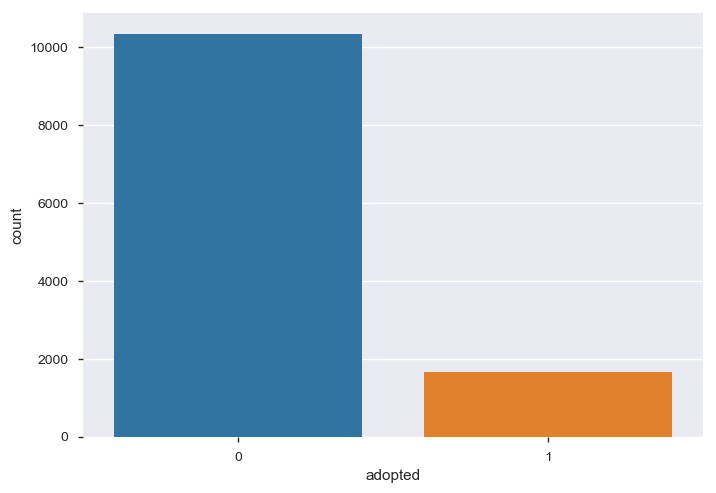

In [8]:
sns.countplot(data=users,
                  x ='adopted')

In [9]:
percent_adopted = (users['adopted'].value_counts()/len(users['adopted'])) *100
percent_adopted

0    86.2
1    13.8
Name: adopted, dtype: float64

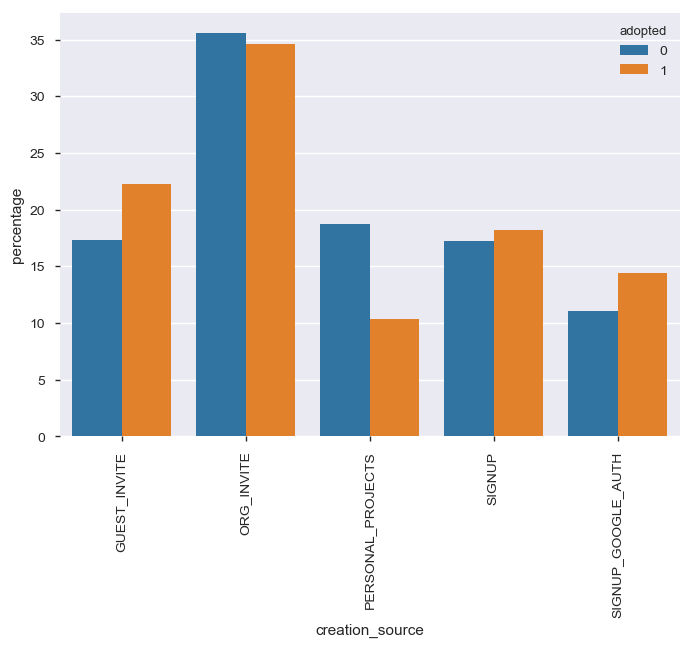

In [10]:
b   =(users.groupby(['adopted'])["creation_source"]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values("creation_source"))
p = sns.barplot(x="creation_source", y="percentage", hue="adopted", data=b)
_ = plt.setp(p.get_xticklabels(), rotation=90)

In [11]:
adopted = users[users.adopted == 1]
unadopted = users[users.adopted == 0]

In [12]:
pandas_profiling.ProfileReport(adopted)

Number of variables,12
Number of observations,1656
Total Missing (%),3.6%
Total size in memory,155.3 KiB
Average record size in memory,96.0 B
Numeric,4
Categorical,2
Boolean,2
Date,0
Text (Unique),2
Rejected,2


In [13]:
pandas_profiling.ProfileReport(unadopted)

Number of variables,12
Number of observations,10344
Total Missing (%),6.5%
Total size in memory,969.8 KiB
Average record size in memory,96.0 B
Numeric,4
Categorical,4
Boolean,2
Date,0
Text (Unique),0
Rejected,2
